# 資源消費量可視化

## 概要

開始日時・終了日時を指定して、その間の各種リソース消費量を計測します。  
本Notebookは、jupyterhubで起動する各single-user notebook serverコンテナのリソース制限値の設定のための情報収集のために用いることを意図しています。  
他のメトリクスデータを収集する場合は、内容を修正して実行してください。

* 前提
    * prometheusのバージョン: `1.7.2`
        * {vcc_ip}:9090 にアクセスして、`Status` -> `Runtime & Build Information`中に記載
* 実行方法
    * 各セルの説明に従って、実行してください
    * 初期状態では、出力例として、アウトプットを残しています。

## HTTP API によるデータ取得

https://prometheus.io/docs/prometheus/latest/querying/api/

\*他には、Pythonライブラリ [`prometheus_api_client`](https://prometheus-api-client-python.readthedocs.io/en/latest/source/prometheus_api_client.html) があります。

### metric一覧の確認

以下のセルを実行すると、prometheusから取得できるメトリック一覧を取得します。  
正常に取得できない場合は、接続先を確認してください。  

* Tips
    * service版VCCの場合、`URL_PROMETHEUS`に`http://10.0.0.1:9090`を指定してください


In [278]:
import requests

URL_PROMETHEUS = 'http://localhost:9090'
URL_PROMETHEUS_API = f'{URL_PROMETHEUS}/api/v1/'
response = requests.get(f'{URL_PROMETHEUS_API}/label/__name__/values')
metrics = response.json()
metrics['data']

['cadvisor_version_info',
 'container_blkio_device_usage_total',
 'container_cpu_cfs_periods_total',
 'container_cpu_cfs_throttled_periods_total',
 'container_cpu_cfs_throttled_seconds_total',
 'container_cpu_load_average_10s',
 'container_cpu_system_seconds_total',
 'container_cpu_usage_seconds_total',
 'container_cpu_user_seconds_total',
 'container_fs_inodes_free',
 'container_fs_inodes_total',
 'container_fs_io_current',
 'container_fs_io_time_seconds_total',
 'container_fs_io_time_weighted_seconds_total',
 'container_fs_limit_bytes',
 'container_fs_read_seconds_total',
 'container_fs_reads_bytes_total',
 'container_fs_reads_merged_total',
 'container_fs_reads_total',
 'container_fs_sector_reads_total',
 'container_fs_sector_writes_total',
 'container_fs_usage_bytes',
 'container_fs_write_seconds_total',
 'container_fs_writes_bytes_total',
 'container_fs_writes_merged_total',
 'container_fs_writes_total',
 'container_last_seen',
 'container_memory_cache',
 'container_memory_failcnt

### 日時等指定

開始時刻・終了時刻・取得スパンを指定します。  
start, endが開始日時・終了日時です。`rfc3339`もしくは`unix_timestamp`形式で指定します。  
stepは、取得間隔（秒）です。例えば、`60`を指定すると、60秒ごとのデータが取得できます。  
※prometheusのスクレイプ間隔より短くしても、それ以上に細かいデータは取得できません。

In [375]:
start = '2024-07-04T04:05:00.000Z'
end = '2024-07-04T04:15:00.000Z'
step = 60

以下のセルを実行することで、指定した期間の資源消費量を取得します。

In [376]:
import requests

# 以下は、開始・終了時刻の別の指定方法として、現在時刻~30分前までを指定する場合のサンプルを記載しています
# import datetime
# END_DATETIME = datetime.datetime.now(datetime.timezone.utc)
# START_DATETIME = END_DATETIME - datetime.timedelta(minutes=30)
# start = START_DATETIME.strftime("%Y-%m-%dT%H:%M:%SZ")
# end = END_DATETIME.strftime("%Y-%m-%dT%H:%M:%SZ")
# step = 60

# single-user notebook serverコンテナごとのメモリ消費量
targets = "jupyter-.*"
query = f'sum(container_memory_rss{{container_label_com_docker_swarm_service_name=~"{targets}"}}) by (name) /1000000'
url = f'{URL_PROMETHEUS_API}/query_range?query={requests.utils.quote(query)}&start={start}&end={end}&step={step}'
response = requests.get(url)
container_memory_rss = response.json()

# インスタンスごとのCPU使用率
query = 'sum(rate(container_cpu_usage_seconds_total{instance=~".+",id="/"}[5m])) by(instance) * 100'
url = f'{URL_PROMETHEUS_API}/query_range?query={requests.utils.quote(query)}&start={start}&end={end}&step={step}'
response = requests.get(url)
container_cpu_usage_seconds_total = response.json()


### 最大値・最小値・平均値

In [372]:
# {'title': metrics(promQLの戻り値)} を指定する
metics = {'cpu_usage_per_instance(%)': container_cpu_usage_seconds_total,
          'memory_usage_per_container(MB)': container_memory_rss,}

以下のセルを実行すると、先に取得したcpu使用率とメモリ消費量の最大値・最小値・平均値を表形式で表示します。  
表は全体での値と、個別（インスタンス毎、もしくはコンテナ毎）の値の両方を表示します。

In [387]:
import pandas as pd
from IPython.display import display, HTML

def get_metric_info(pr_result, key='name'):
    
    m_max, m_min, m_sum, m_cnt = None, None, 0, 0
    items_info = dict()
    for d in pr_result['data']['result']:
        name = d['metric'].get(key)
        if name is None:
            name = d['metric'].get('instance')
        if name is None:
            continue

        values = [float(v[1]) for v in d['values']]
        v_min = min(values)
        v_max = max(values)
        v_sum = sum(values)
        v_cnt = len(values)

        items_info[name] = {
            'max': v_max,
            'min': v_min,
            'sum': v_sum,
            'cnt': v_cnt,
        }

        m_min = min(v_min, m_min) if m_min is not None else v_min
        m_max = max(v_max, m_max) if m_max is not None else v_max
        m_sum += v_sum
        m_cnt += v_cnt
    
    return {'min': m_min, 'max': m_max, 'sum': m_sum, 'cnt': m_cnt, 'targets': items_info}


df_info = {'name': [], 'min': [], 'max': [], 'avg': []}
df_detail_info = dict()
for metric_name, metric in metics.items():
    res = get_metric_info(metric)
    # 全体
    df_info['name'].append(metric_name)
    df_info['min'].append(res['min'])
    df_info['max'].append(res['max'])
    if res['cnt'] == 0:
        v = None
    else:
        v = res['sum']/res['cnt']
    df_info['avg'].append(v)
    
    # 個別
    df_detail_info[metric_name] = {'name': [], 'min': [], 'max': [], 'avg': []}
    for target_name, value in res['targets'].items():
        df_detail_info[metric_name]['name'].append(target_name)
        df_detail_info[metric_name]['min'].append(value['min'])
        df_detail_info[metric_name]['max'].append(value['max'])
        df_detail_info[metric_name]['avg'].append(value['sum']/value['cnt'])
    

display(HTML("<h1>全体</h1>"))

df = pd.DataFrame(df_info)
df = df.set_index('name')
display(df)

display(HTML("<h1>個別</h1>"))
df_detail = pd.DataFrame(df_detail_info)
for metric_name, detail in df_detail_info.items():
    df_detail = pd.DataFrame(detail)
    df_detail = df_detail.set_index('name')
    styled_df_detail = df_detail.style.set_caption(metric_name).set_table_styles(
        [{'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold')]}]
    )
    display(styled_df_detail)


,min,max,avg
name,,,
cpu_usage_per_instance(%),15.570887,77.612717,17.779174
memory_usage_per_container(MB),66.797568,1064.366080,395.002539


,min,max,avg
name,,,
10.17.153.195:18083,8.814741,9.243542,9.024553
10.17.153.76:18083,2.758847,3.139048,2.914444
10.17.157.53:18083,15.570887,77.612717,41.398523


,min,max,avg
name,,,
jupyter-2.1.md571f6nejb52fibk10wexgba,72.970240,1051.131904,253.825414
jupyter-3.1.rvvi421hu8lyl59iliepq2kyo,66.797568,1064.366080,536.179663


## 描画

以下のセルは、描画用関数の定義です。セルをそのまま実行してください。

In [329]:
import datetime

from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.colors import cnames


def plot_values(data: dict, metric_key_label='name', title=None,
                x_label=None, y_label=None, stack=False, value_round=False):
    """promQLで取得したデータをグラフで表示する


    Args:
        data (dict): promQLで取得したデータ
        metric_key_label (str, optional): 凡例に表示する各メトリックのKey名
        title (str, optional): グラフタイトル
        x_label (str, optional): x軸ラベル
        y_label (str, optional): y軸ラベル
        stack (bool, optional): Trueを指定した場合、積み上げグラフになる
        value_round (bool, optional): Trueを指定した場合、y軸の値を整数に丸める

    Returns:
        None

    Examples:

        関数の使い方


        >>> plot_values(container_memory_rss, title='container_memory_rss',
                        x_label='time', y_label='memory(MB)', value_round=True)

    Note:
        入力値は、promQLで取得できるresult type: `matrix`のデータ構造を想定している。
        ex.) [
              {
                "metric": { "<label_name>": "<label_value>", ... },
                "values": [ [ <unix_time>, "<sample_value>" ], ... ],
                "histograms": [ [ <unix_time>, <histogram> ], ... ]
              },
              ...
             ]
            (https://prometheus.io/docs/prometheus/latest/querying/api/#expression-query-result-formats)
    """
    
    def _get_max_values_index(values):
        max_idx = 0
        max_values = 0
        for i, d in enumerate(values):
            if len(d['values']) > max_values:
                max_values = len(d['values'])
                max_idx = i
        return max_idx
    
    pr_result = data['data']['result']
    if len(pr_result) == 0:
        print(f'No data: {title}')
        return

    plt.rcParams['axes.prop_cycle']  = cycler(color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2','#59A14E',
                                                 '#EDC949','#B07AA2','#FF9DA7','#9C755F','#BAB0AC'])

    fig, ax = plt.subplots(figsize=[10, 4.2])
    plt.figure(figsize=[10, 4.2])
    
    # 先頭データを基準とする
    x = [datetime.datetime.fromtimestamp(
            values[0],
            datetime.timezone(
                datetime.timedelta(hours=9)
            )
             ).strftime('%H:%M') for values in pr_result[_get_max_values_index(pr_result)]['values']
        ]
    
    y_values = list()
    labels =list()
    for d in pr_result:
        label = d['metric'].get(metric_key_label)
        if label is None:
            continue

        if value_round:
            y = [int(float(d[1])) for d in d['values']]
        else:
            y = [float(d[1]) for d in d['values']]

        # データが足りない場合は0で埋める
        if len(x) - len(y) > 0:
            y.extend([0 for i in range(len(x) - len(y))])

        if stack:
            y_values.append(y)
            labels.append(label)
        else:
            ax.plot(x, y, label=label)

    if stack:
        ax.stackplot(x, *y_values, labels=labels)

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(title, c="darkred", size="large")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # 凡例は数が多いとグラフに被るので、グラフ右枠外に表示
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

以下のセルは、上記描画用関数定義の呼び出し例です。  
実行すると、先に取得した資源消費量を図示します。

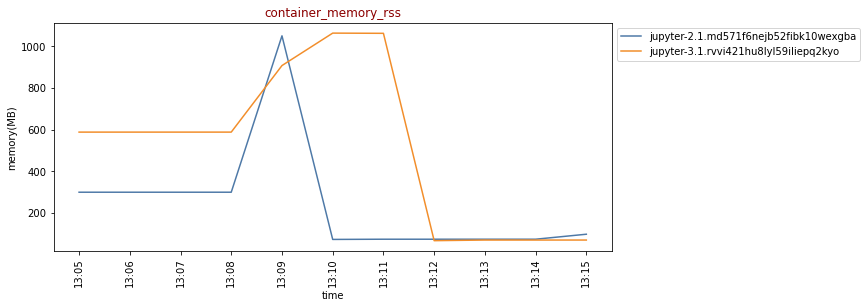

<Figure size 720x302.4 with 0 Axes>

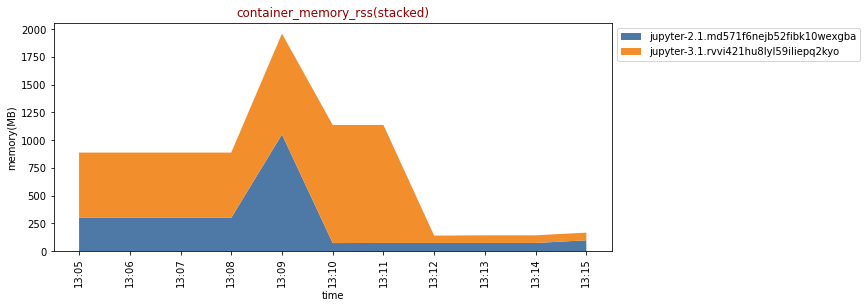

<Figure size 720x302.4 with 0 Axes>

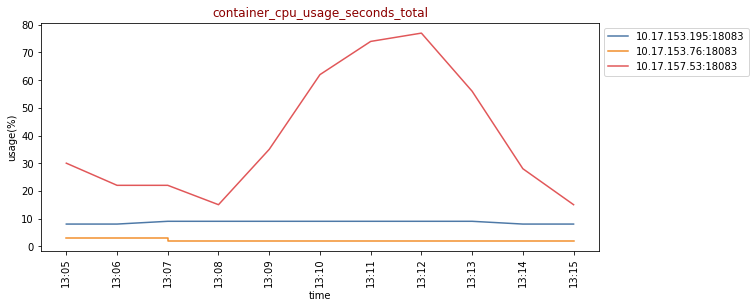

<Figure size 720x302.4 with 0 Axes>

In [338]:
plot_values(container_memory_rss, title='container_memory_rss', x_label='time', y_label='memory(MB)', value_round=True)
plot_values(container_memory_rss, title='container_memory_rss(stacked)', x_label='time', y_label='memory(MB)', value_round=True, stack=True)

plot_values(container_cpu_usage_seconds_total, metric_key_label='instance', title='container_cpu_usage_seconds_total', x_label='time', y_label='usage(%)', value_round=True)